# Implement names generator

Use architecture from Bengio et al

In [1]:
import time
import random

import torch
import matplotlib.pyplot as plt
import numpy as np

In [63]:
# plt.style.use('classic')
plt.style.use('dark_background')

In [2]:
torch.cuda.is_available()

True

In [3]:
def move_to_device(tensors, device):
    new_tensors = [None] * len(tensors)
    with torch.no_grad():
        for idx, tensor in enumerate(tensors):
            new_tensors[idx] = tensor.to(device, copy=True)
    return new_tensors

### Prepare dataset

In [4]:
with open('names.txt', 'r') as f:
    words = f.read().splitlines()
    random.shuffle(words)


In [39]:
block_size = 4

In [40]:
all_letters = set(sum((list(s) for s in words), []))

In [41]:
all_symbols = all_letters.union({'.'})
stoi = {'.': 0}
stoi.update({letter: idx for idx, letter in enumerate(all_letters, 1)})
itos = {idx: letter for letter, idx in stoi.items()}

# create dataset
X = list()
y = list()
for word in words:
    word = block_size * '.' + word + '.'
    for idx in range(block_size, len(word)):
        prev = word[(idx-block_size):idx]
        X.append(list(stoi[s] for s in prev))
        y.append(stoi[word[idx]])

X = torch.tensor(X)
y = torch.tensor(y)

In [42]:
def split_dataset(X, y):
    total_len = X.shape[0]
    
    n1 = int(0.8 * total_len)
    n2 = int(0.9 * total_len)

    return (X[:n1], y[:n1]), (X[n1:n2], y[n1:n2]), (X[n2:], y[n2:])

    # num_tr = round(0.6 * total_len)
    # num_val = round(0.2 * total_len)
    # num_test = total_len - num_tr - num_val
    # idx_tr, idx_val, idx_test = torch.utils.data.random_split(range(X.shape[0]), [num_tr, num_val, num_test])
    # return (X[idx_tr], y[idx_tr]), (X[idx_val], y[idx_val]), (X[idx_test], y[idx_test])

In [43]:
(Xtr, ytr), (Xval, yval), (Xtest, ytest) = split_dataset(X, y)

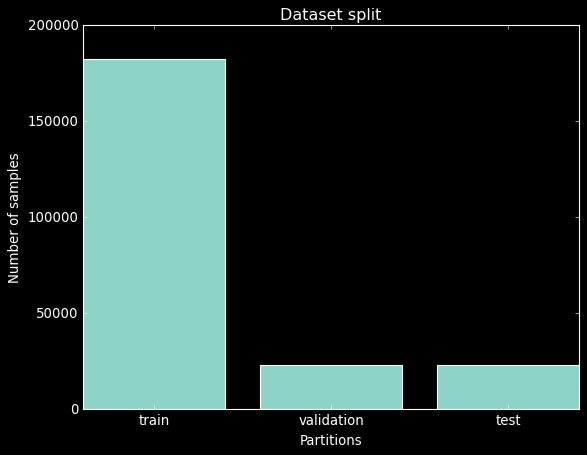

In [88]:
_, ax = plt.subplots(1, 1)
ax.set_title("Dataset split")
ax.set_xlabel("Partitions")
ax.set_ylabel("Number of samples")
ax.bar(['train', 'validation', 'test'], [len(Xtr), len(Xval), len(Xtest)])
plt.show()

### Define model class, loss and training loop

In [89]:
class Introspector:
    def __init__(self):
        self.first_layer_volume = None
        self.second_layer_activations = None
        self.third_layer_activations = None

In [96]:
class Model:
    def __init__(self):
        # HPs
        self.embeddings_len = 15
        self.hidden_nodes1 = 400
        # self.hidden_nodes2 = 400

        # Initialize parameters        
        self.C = torch.randn((len(all_symbols), self.embeddings_len)) # matrix of embeddings
        self.C.requires_grad = True

        self.biases1 = torch.randn(self.hidden_nodes1) * 0.01
        self.biases1.requires_grad = True

        self.weights1 = torch.randn((block_size * self.embeddings_len, self.hidden_nodes1)) * ((5 / 3) / np.sqrt(block_size * self.embeddings_len))
        self.weights1.requires_grad = True

        # self.biases2 = torch.randn(self.hidden_nodes2) * 0.01
        # self.biases2.requires_grad = True

        # self.weights2 = torch.randn((self.hidden_nodes1, self.hidden_nodes2)) * ((5 / 3) / np.sqrt(self.hidden_nodes1))
        # self.weights2.requires_grad = True

        self.biases2 = torch.randn(len(all_symbols)) * 0.01
        self.biases2.requires_grad = True

        self.weights2 = torch.randn((self.hidden_nodes1, len(all_symbols))) * (1 / np.sqrt(self.hidden_nodes1)) * 0.5
        self.weights2.requires_grad = True
        
        self.introspector = Introspector()

    def create_preds(self, X):
        c = self.C[X]

        first_layer_volume = c.view(X.shape[0], -1)

        second_layer_volume = (first_layer_volume @ self.weights1) + self.biases1
        second_layer_activations = torch.tanh(second_layer_volume)

        third_layer_volume = (second_layer_activations @ self.weights2) + self.biases2
        third_layer_activations = torch.softmax(third_layer_volume, 1)

        self.introspector.first_layer_volume = first_layer_volume
        self.introspector.second_layer_activations = second_layer_activations
        self.introspector.third_layer_activations = third_layer_activations

        return third_layer_activations

    def parameters(self):
        return [self.C, self.biases1, self.weights1, self.biases2, self.weights2]

    def move_to_device(self, device):
        parameters = move_to_device(self.parameters(), device)
        for p in parameters:
            p.requires_grad = True
        self.C, self.biases1, self.weights1, self.biases2, self.weights2 = parameters


In [97]:
def create_loss(predictions, actual):
    return - predictions[range(len(predictions)), actual].log().mean()


In [98]:
def training_loop(model: Model, num_iters, batch_size, lr):
    start_ts = time.time()
    
    print(f"Iter #0", )
    with torch.no_grad():
        train_loss = create_loss(model.create_preds(Xtr), ytr).item()
        val_loss = create_loss(model.create_preds(Xval), yval).item()
    print(f"\ttrain_loss = {train_loss:.2f}")
    print(f"\tval_loss = {val_loss:.2f}\n")

    for num_iter in range(num_iters):
        # get batch
        indices = torch.randint(0, len(Xtr) - 1, (batch_size,))
        batch_X = Xtr[indices]
        batch_y = ytr[indices]
        # batch_X = Xtr
        # batch_y = ytr
        
        # calculate loss
        loss = create_loss(model.create_preds(batch_X), batch_y)

        # zerograd
        for parameter_tensor in model.parameters():
            parameter_tensor.grad = None

        # backprop
        loss.backward()

        # update weights
        for parameter_tensor in model.parameters():
            parameter_tensor.data -= lr * parameter_tensor.grad

        # display train and validation losses
        if ((num_iter + 1) % 10_000) == 0:
            print(f"Iter #{num_iter+1}", )
            with torch.no_grad():
                train_loss = create_loss(model.create_preds(Xtr), ytr).item()
                val_loss = create_loss(model.create_preds(Xval), yval).item()
            print(f"\ttrain_loss = {train_loss:.2f}")
            print(f"\tval_loss = {val_loss:.2f}\n")

        # if time.time() - start_ts >= max_time:
        #     break


### Train the model and validate HPs

In [99]:
# Create model
model = Model()

# Move to device
# device = torch.device('cuda', 0)
device = torch.device('cpu')
model.move_to_device(device)
Xtr, ytr, Xval, yval = move_to_device(
    [
        Xtr, ytr, Xval, yval
    ],
    device
)

In [100]:
batch_size = 32

lr = 0.1
training_loop(model, 50_000, batch_size, lr)

lr = 0.001
training_loop(model, 50_000, batch_size, lr)

lr = 0.0001
training_loop(model, 50_000, batch_size, lr)

Iter #0
	train_loss = 3.33
	val_loss = 3.32

Iter #10000
	train_loss = 2.21
	val_loss = 2.25

Iter #20000
	train_loss = 2.15
	val_loss = 2.21

Iter #30000
	train_loss = 2.12
	val_loss = 2.20

Iter #40000
	train_loss = 2.07
	val_loss = 2.16

Iter #50000
	train_loss = 2.05
	val_loss = 2.16

Iter #0
	train_loss = 2.05
	val_loss = 2.16

Iter #10000
	train_loss = 1.94
	val_loss = 2.04

Iter #20000
	train_loss = 1.93
	val_loss = 2.03

Iter #30000
	train_loss = 1.92
	val_loss = 2.03

Iter #40000
	train_loss = 1.92
	val_loss = 2.03

Iter #50000
	train_loss = 1.92
	val_loss = 2.03

Iter #0
	train_loss = 1.92
	val_loss = 2.03

Iter #10000
	train_loss = 1.92
	val_loss = 2.02

Iter #20000
	train_loss = 1.92
	val_loss = 2.02

Iter #30000
	train_loss = 1.92
	val_loss = 2.02

Iter #40000
	train_loss = 1.92
	val_loss = 2.02

Iter #50000
	train_loss = 1.92
	val_loss = 2.02



Validate different combinations to choose the one that produces the lowest score after one minute of training.

The results are available in `1min_validate_hps.txt`

In [ ]:
for device in ['cpu', 'cuda:0']:
    for batch_size in [1, 64, 1024]:
        for lr in [0.01, 0.1]:
            model = Model()
            model.move_to_device(device)
            training_loop(model, 10**100, batch_size, lr, 60)
            print("Loss for config")
            print(f"\tdevice = {device}")
            print(f"\tbatch_size = {batch_size}")
            print(f"\tlr = {lr}")
            print(create_loss(model.create_preds(Xtr), ytr).item())
            print("-" * 50)

### "Model introspection"

The loss when all labels are given equal probability (no reason to give higher probability to one of the labels):

In [19]:
print('"Expected" loss:', -np.log(1 / len(all_symbols)))

"Expected" loss: 3.295836866004329


In [82]:
model_ = Model()
loss = create_loss(model_.create_preds(Xtr), ytr)

print('Actual loss:', loss.item())

Actual loss: 3.35502290725708


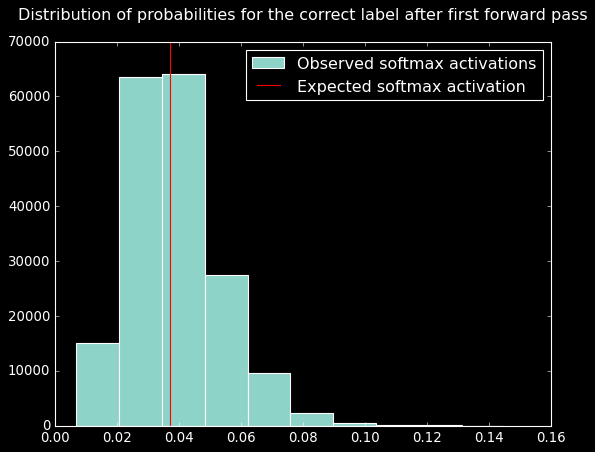

In [76]:
s = model_.introspector.third_layer_activations[list(range(len(ytr))), ytr]
plt.figure()
plt.title("Distribution of probabilities for the correct label after first forward pass", pad=20)
plt.hist(s.detach().numpy(), label='Observed softmax activations')
plt.axvline(x=1/len(all_symbols), color='r', label='Expected softmax activation')
plt.legend()
plt.show()

/tmp/ipykernel_7854/1668140508.py:4: RuntimeWarning: divide by zero encountered in arctanh
  ax[0].scatter(np.arctanh(acts), acts, marker='.')


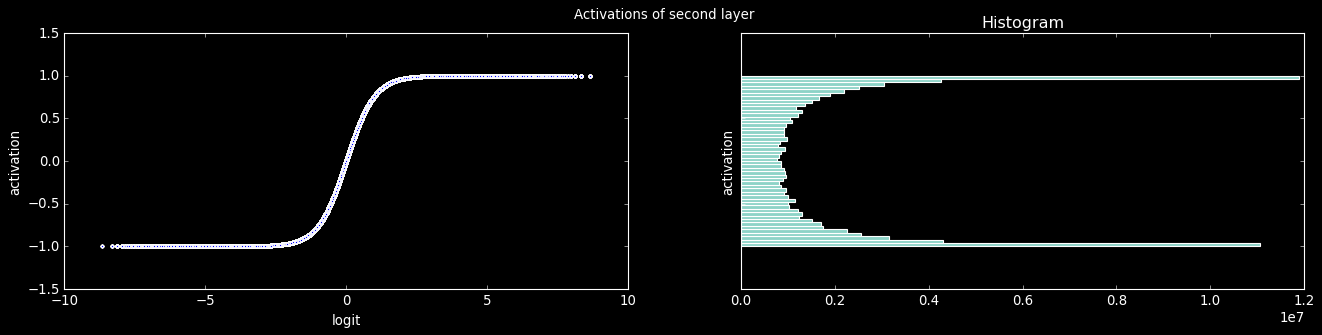

In [72]:
acts = model_.introspector.second_layer_activations.detach().numpy().reshape(-1)
fig, ax = plt.subplots(1, 2, figsize=(20, 4), sharey=True)
fig.suptitle("Activations of second layer")
ax[0].scatter(np.arctanh(acts), acts, marker='.')
ax[0].set_xlabel('logit')
ax[0].set_ylabel('activation')
ax[1].set_title('Histogram')
ax[1].hist(acts, orientation='horizontal', bins=50)
ax[1].set_ylabel('activation')
plt.show()

### Differentiation of a cross-entropy of a single example with respect to the $j^{th}$ logit.
$w_t$-th logit corresponds to the true label

$$
L = log(p_{w_t})
$$
$$
L = log(p_{w_t}) = log(\frac{e^{y_{w_t}}}{\sum e^{y_i}})
$$

$$
\frac{\partial L}{\partial y_{w_t}} = \frac{1}{p_{w_t}} \cdot \frac{e^{y_{w_t}} (\sum e^{y_i}) - e^{2 y_{w_t}}}{(\sum e^{y_i})^2}
$$

$$
\frac{\partial L}{\partial y_{w_t}} = \frac{1}{p_{w_t}} \cdot (p_{w_t} - p_{w_t}^2) = 1 - p_{w_t}
$$

$$
\frac{\partial L}{\partial y_{j}} = \frac{- e^{y_{j}}}{\sum e^{y_i}} = - p_j
$$